<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/muga01/python_basics/blob/main/notebooks/figures/PDSH-cover-small.png?raw=1">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb) | [Contents](Index.ipynb) | [Vectorized String Operations](03.10-Working-With-Strings.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.09-Pivot-Tables.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Pivot Tables

We have seen how the ``GroupBy`` abstraction lets us explore relationships within a dataset.
A *pivot table* is a similar operation that is commonly seen in spreadsheets and other programs that operate on tabular data.
The pivot table takes simple column-wise data as input, and groups the entries into a two-dimensional table that provides a multidimensional summarization of the data.
The difference between pivot tables and ``GroupBy`` can sometimes cause confusion; it helps me to think of pivot tables as essentially a *multidimensional* version of ``GroupBy`` aggregation.
That is, you split-apply-combine, but both the split and the combine happen across not a one-dimensional index, but across a two-dimensional grid.

## Motivating Pivot Tables

For the examples in this section, we'll use the database of passengers on the *Titanic*, available through the Seaborn library (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)):

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [2]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


This contains a wealth of information on each passenger of that ill-fated voyage, including gender, age, class, fare paid, and much more.

## Pivot Tables by Hand

To start learning more about this data, we might begin by grouping according to gender, survival status, or some combination thereof.
If you have read the previous section, you might be tempted to apply a ``GroupBy`` operation–for example, let's look at survival rate by gender:

In [4]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


This immediately gives us some insight: overall, three of every four females on board survived, while only one in five males survived!

This is useful, but we might like to go one step deeper and look at survival by both sex and, say, class.
Using the vocabulary of ``GroupBy``, we might proceed using something like this:
we *group by* class and gender, *select* survival, *apply* a mean aggregate, *combine* the resulting groups, and then *unstack* the hierarchical index to reveal the hidden multidimensionality. In code:

In [5]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This gives us a better idea of how both gender and class affected survival, but the code is starting to look a bit garbled.
While each step of this pipeline makes sense in light of the tools we've previously discussed, the long string of code is not particularly easy to read or use.
This two-dimensional ``GroupBy`` is common enough that Pandas includes a convenience routine, ``pivot_table``, which succinctly handles this type of multi-dimensional aggregation.

## Pivot Table Syntax

Here is the equivalent to the preceding operation using the ``pivot_table`` method of ``DataFrame``s:

In [6]:
titanic.pivot_table('survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This is eminently more readable than the ``groupby`` approach, and produces the same result.
As you might expect of an early 20th-century transatlantic cruise, the survival gradient favors both women and higher classes.
First-class women survived with near certainty (hi, Rose!), while only one in ten third-class men survived (sorry, Jack!).

### Multi-level pivot tables

Just as in the ``GroupBy``, the grouping in pivot tables can be specified with multiple levels, and via a number of options.
For example, we might be interested in looking at age as a third dimension.
We'll bin the age using the ``pd.cut`` function:

In [8]:
titanic['age']

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: age, Length: 891, dtype: float64

In [28]:
age = pd.cut(titanic['age'], [0,18,36,80])
fare = pd.cut(titanic['fare'],[0,50,75,600])
titanic.pivot_table('survived', ['sex',age], [fare,'class'])


fare              (0, 50]                      (50, 75]              (75, 600]
class               First    Second     Third     First Second Third     First
sex    age                                                                    
female (0, 18]   1.000000  1.000000  0.511628  1.000000    NaN   NaN  0.875000
       (18, 36]  1.000000  0.928571  0.511111  1.000000    1.0   NaN  0.960000
       (36, 80]  0.833333  0.812500  0.142857  1.000000    1.0   NaN  1.000000
male   (0, 18]        NaN  0.642857  0.215686       NaN    0.0   NaN  0.800000
       (18, 36]  0.666667  0.074074  0.131579  0.500000    0.0  0.75  0.384615
       (36, 80]  0.275862  0.076923  0.071429  0.307692    NaN   NaN  0.333333

We can apply the same strategy when working with the columns as well; let's add info on the fare paid using ``pd.qcut`` to automatically compute quantiles:

In [30]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 14.454]            ... (14.454, 512.329]          
class                      First    Second  ...            Second     Third
sex    age                                  ...                            
female (0, 18]               NaN  1.000000  ...          1.000000  0.318182
       (18, 36]              NaN  0.944444  ...          0.920000  0.571429
       (36, 80]              NaN  0.714286  ...          0.900000  0.111111
male   (0, 18]               NaN  0.000000  ...          0.818182  0.178571
       (18, 36]              0.0  0.083333  ...          0.045455  0.250000
       (36, 80]              0.0  0.133333  ...          0.000000  0.000000

[6 rows x 6 columns]

The result is a four-dimensional aggregation with hierarchical indices (see [Hierarchical Indexing](03.05-Hierarchical-Indexing.ipynb)), shown in a grid demonstrating the relationship between the values.

### Additional pivot table options

The full call signature of the ``pivot_table`` method of ``DataFrame``s is as follows:

```python
# call signature as of Pandas 0.18
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')
```

We've already seen examples of the first three arguments; here we'll take a quick look at the remaining ones.
Two of the options, ``fill_value`` and ``dropna``, have to do with missing data and are fairly straightforward; we will not show examples of them here.

The ``aggfunc`` keyword controls what type of aggregation is applied, which is a mean by default.
As in the GroupBy, the aggregation specification can be a string representing one of several common choices (e.g., ``'sum'``, ``'mean'``, ``'count'``, ``'min'``, ``'max'``, etc.) or a function that implements an aggregation (e.g., ``np.sum()``, ``min()``, ``sum()``, etc.).
Additionally, it can be specified as a dictionary mapping a column to any of the above desired options:

In [37]:
pd.pivot_table(titanic,index=['sex'],columns=['class'],aggfunc={'survived':sum,'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

In [38]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':sum, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Notice also here that we've omitted the ``values`` keyword; when specifying a mapping for ``aggfunc``, this is determined automatically.

At times it's useful to compute totals along each grouping.
This can be done via the ``margins`` keyword:

In [42]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True,margins_name='Total mean')

class,First,Second,Third,Total mean
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
Total mean,0.629630,0.472826,0.242363,0.383838


Here this automatically gives us information about the class-agnostic survival rate by gender, the gender-agnostic survival rate by class, and the overall survival rate of 38%.
The margin label can be specified with the ``margins_name`` keyword, which defaults to ``"All"``.

## Example: Birthrate Data

As a more interesting example, let's take a look at the freely available data on births in the United States, provided by the Centers for Disease Control (CDC).
This data can be found at https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv
(this dataset has been analyzed rather extensively by Andrew Gelman and his group; see, for example, [this blog post](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)):

In [ ]:
# shell command to download the data:
# !curl -O https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

In [80]:
births = pd.read_csv('https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv')

In [44]:
births.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15547 entries, 0 to 15546
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    15547 non-null  int64  
 1   month   15547 non-null  int64  
 2   day     15067 non-null  float64
 3   gender  15547 non-null  object 
 4   births  15547 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 607.4+ KB


In [45]:
births['year'].unique()

array([1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008])

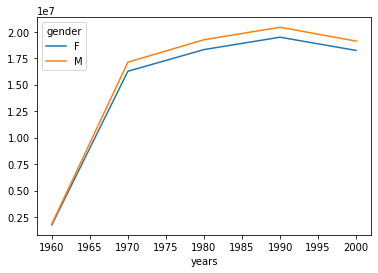

In [67]:
#1999 --> 1990
#1987 --> 1980
#2001 --> 2000
#1972 --> 1970
#(2001//10)*10
births['years'] = (births['year']//10)*10

births.pivot_table('births',index=['gender'], columns=['years'],aggfunc=sum,margins=False,margins_name='Total').T.plot()

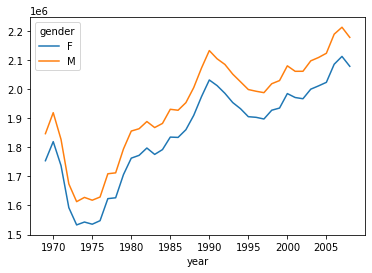

In [68]:
births.pivot_table('births',index=['gender'], columns=['year'],aggfunc=sum,margins=False,margins_name='Total').T.plot()

Taking a look at the data, we see that it's relatively simple–it contains the number of births grouped by date and gender:

In [ ]:
births.head()

,year,month,day,gender,births
0,1969,1,1,F,4046
1,1969,1,1,M,4440
2,1969,1,2,F,4454
3,1969,1,2,M,4548
4,1969,1,3,F,4548


We can start to understand this data a bit more by using a pivot table.
Let's add a decade column, and take a look at male and female births as a function of decade:

In [120]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


gender,F,M
decade,,
1960,1752836,1845742
1970,16260348,17118785
1980,16336507,17171290


We immediately see that male births outnumber female births in every decade.
To see this trend a bit more clearly, we can use the built-in plotting tools in Pandas to visualize the total number of births by year (see [Introduction to Matplotlib](04.00-Introduction-To-Matplotlib.ipynb) for a discussion of plotting with Matplotlib):

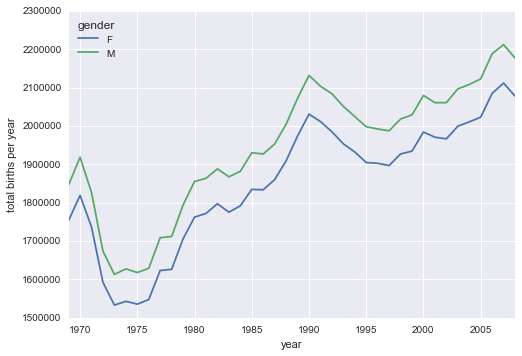

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # use Seaborn styles
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

With a simple pivot table and ``plot()`` method, we can immediately see the annual trend in births by gender. By eye, it appears that over the past 50 years male births have outnumbered female births by around 5%.

### Further data exploration

Though this doesn't necessarily relate to the pivot table, there are a few more interesting features we can pull out of this dataset using the Pandas tools covered up to this point.
We must start by cleaning the data a bit, removing outliers caused by mistyped dates (e.g., June 31st) or missing values (e.g., June 99th).
One easy way to remove these all at once is to cut outliers; we'll do this via a robust sigma-clipping operation:

In [70]:
births['day'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 99., nan])

In [72]:
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

This final line is a robust estimate of the sample mean, where the 0.74 comes from the interquartile range of a Gaussian distribution (You can learn more about sigma-clipping operations in a book I coauthored with Željko Ivezić, Andrew J. Connolly, and Alexander Gray: ["Statistics, Data Mining, and Machine Learning in Astronomy"](http://press.princeton.edu/titles/10159.html) (Princeton University Press, 2014)).

With this we can use the ``query()`` method (discussed further in [High-Performance Pandas: ``eval()`` and ``query()``](03.12-Performance-Eval-and-Query.ipynb)) to filter-out rows with births outside these values:

In [121]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

In [101]:
births.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14610 entries, 0 to 15066
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    14610 non-null  int64  
 1   month   14610 non-null  int64  
 2   day     14610 non-null  float64
 3   gender  14610 non-null  object 
 4   births  14610 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 684.8+ KB


In [78]:
lower_bound = quartiles[0] - 1.5 * (quartiles[2]-quartiles[0])
upper_bound = quartiles[2] + 1.5 * (quartiles[2]-quartiles[0])

new_births = births.query(("(births > @lower_bound) & (births < @upper_bound)"))
new_births.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14610 entries, 0 to 15066
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    14610 non-null  int64  
 1   month   14610 non-null  int64  
 2   day     14610 non-null  float64
 3   gender  14610 non-null  object 
 4   births  14610 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 684.8+ KB


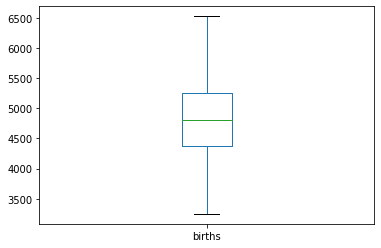

In [79]:
new_births['births'].plot(kind='box')

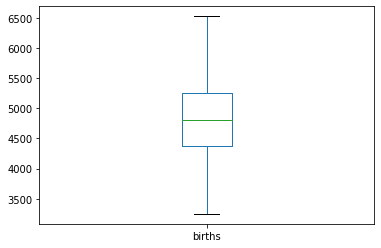

In [102]:
births['births'].plot(kind='box')

In [92]:
x = (births['births'] > lower_bound) & (births['births'] < upper_bound)
y = births.loc[x==False,'births']

In [76]:
quartiles

array([4358. , 4814. , 5289.5])

Next we set the ``day`` column to integers; previously it had been a string because some columns in the dataset contained the value ``'null'``:

In [122]:
# set 'day' column to integer; it originally was a string due to nulls
births['day'] = births['day'].astype(int)

In [106]:
births['day'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [107]:
births.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14610 entries, 0 to 15066
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    14610 non-null  int64 
 1   month   14610 non-null  int64 
 2   day     14610 non-null  int64 
 3   gender  14610 non-null  object
 4   births  14610 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 684.8+ KB


Finally, we can combine the day, month, and year to create a Date index (see [Working with Time Series](03.11-Working-with-Time-Series.ipynb)).
This allows us to quickly compute the weekday corresponding to each row:

In [109]:
year = 1980
month = 12
day = 6
1980*10000 + 12 *100 + 6 format=%yyyy%mm%dd

19801206

In [123]:
# create a datetime index from the year, month, day
births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format='%Y%m%d')

births['dayofweek'] = births.index.dayofweek
births['weekofyear'] = births.index.weekofyear
births['weekday'] = births.index.day_name()
births

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys


,year,month,day,gender,births,dayofweek,weekofyear,weekday,decade
1969-01-01,1969,1,1,F,4046,2,1,Wednesday,1960
1969-01-01,1969,1,1,M,4440,2,1,Wednesday,1960
1969-01-02,1969,1,2,F,4454,3,1,Thursday,1960
1969-01-02,1969,1,2,M,4548,3,1,Thursday,1960
1969-01-03,1969,1,3,F,4548,4,1,Friday,1960
...,...,...,...,...,...,...,...,...,...
1988-12-29,1988,12,29,M,5944,3,52,Thursday,1980
1988-12-30,1988,12,30,F,5742,4,52,Friday,1980
1988-12-30,1988,12,30,M,6095,4,52,Friday,1980
1988-12-31,1988,12,31,F,4435,5,52,Saturday,1980


Using this we can plot births by weekday for several decades:

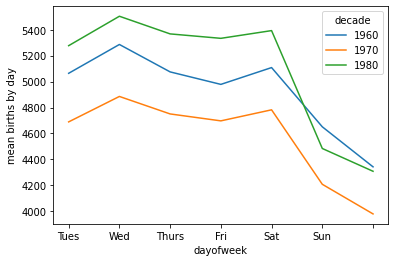

In [124]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index='dayofweek',
                    columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');

Apparently births are slightly less common on weekends than on weekdays! Note that the 1990s and 2000s are missing because the CDC data contains only the month of birth starting in 1989.

Another intersting view is to plot the mean number of births by the day of the *year*.
Let's first group the data by month and day separately:

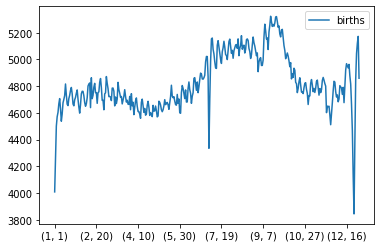

In [126]:
births_by_date = births.pivot_table('births', 
                                    [births.index.month, births.index.day])
births_by_date.plot()

The result is a multi-index over months and days.
To make this easily plottable, let's turn these months and days into a date by associating them with a dummy year variable (making sure to choose a leap year so February 29th is correctly handled!)

In [127]:
births_by_date.index = [pd.datetime(2012, month, day)
                        for (month, day) in births_by_date.index]
births_by_date.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


Focusing on the month and day only, we now have a time series reflecting the average number of births by date of the year.
From this, we can use the ``plot`` method to plot the data. It reveals some interesting trends:

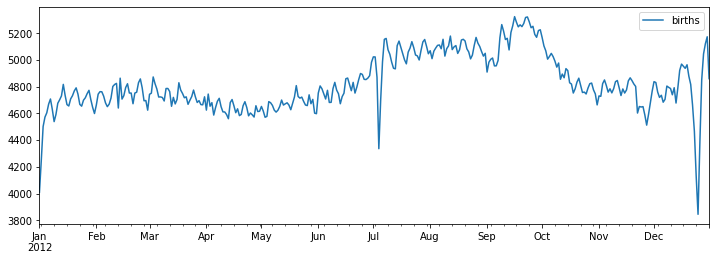

In [128]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);

In particular, the striking feature of this graph is the dip in birthrate on US holidays (e.g., Independence Day, Labor Day, Thanksgiving, Christmas, New Year's Day) although this likely reflects trends in scheduled/induced births rather than some deep psychosomatic effect on natural births.
For more discussion on this trend, see the analysis and links in [Andrew Gelman's blog post](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/) on the subject.
We'll return to this figure in [Example:-Effect-of-Holidays-on-US-Births](04.09-Text-and-Annotation.ipynb#Example:-Effect-of-Holidays-on-US-Births), where we will use Matplotlib's tools to annotate this plot.

Looking at this short example, you can see that many of the Python and Pandas tools we've seen to this point can be combined and used to gain insight from a variety of datasets.
We will see some more sophisticated applications of these data manipulations in future sections!

<!--NAVIGATION-->
< [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb) | [Contents](Index.ipynb) | [Vectorized String Operations](03.10-Working-With-Strings.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.09-Pivot-Tables.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
